# Semantic Segmentation: Fluorescent Neuronal Cells 

## Setup

In [1]:
import os
import random

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from icecream import ic

import torch
from torch.utils.data import DataLoader

import albumentations as A

import pytorch_lightning as pl

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation, SegformerImageProcessor
from datasets import Dataset, load_dataset, DatasetDict
import evaluate

In [2]:
MODEL_CHECKPOINT = "nvidia/segformer-b0-finetuned-ade-512-512"

# Define the accelerator
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps:0")
    ACCELERATOR = "mps"
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    ACCELERATOR = "gpu"
else:
    DEVICE = torch.device("cpu")
    ACCELERATOR = "cpu"

RAW_DATA_PATH = "../data/raw/"
DATA_PATH = "../data/processed/"



## Dataset

In [3]:
image_name = random.choice(os.listdir(os.path.join(RAW_DATA_PATH, "all_images", "images")))
image_path = os.path.join(RAW_DATA_PATH, "all_images", "images", image_name)
mask_path = os.path.join(RAW_DATA_PATH, "all_masks", "masks", image_name)

orig_image = np.array(Image.open(image_path), dtype=np.uint8)
orig_mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)


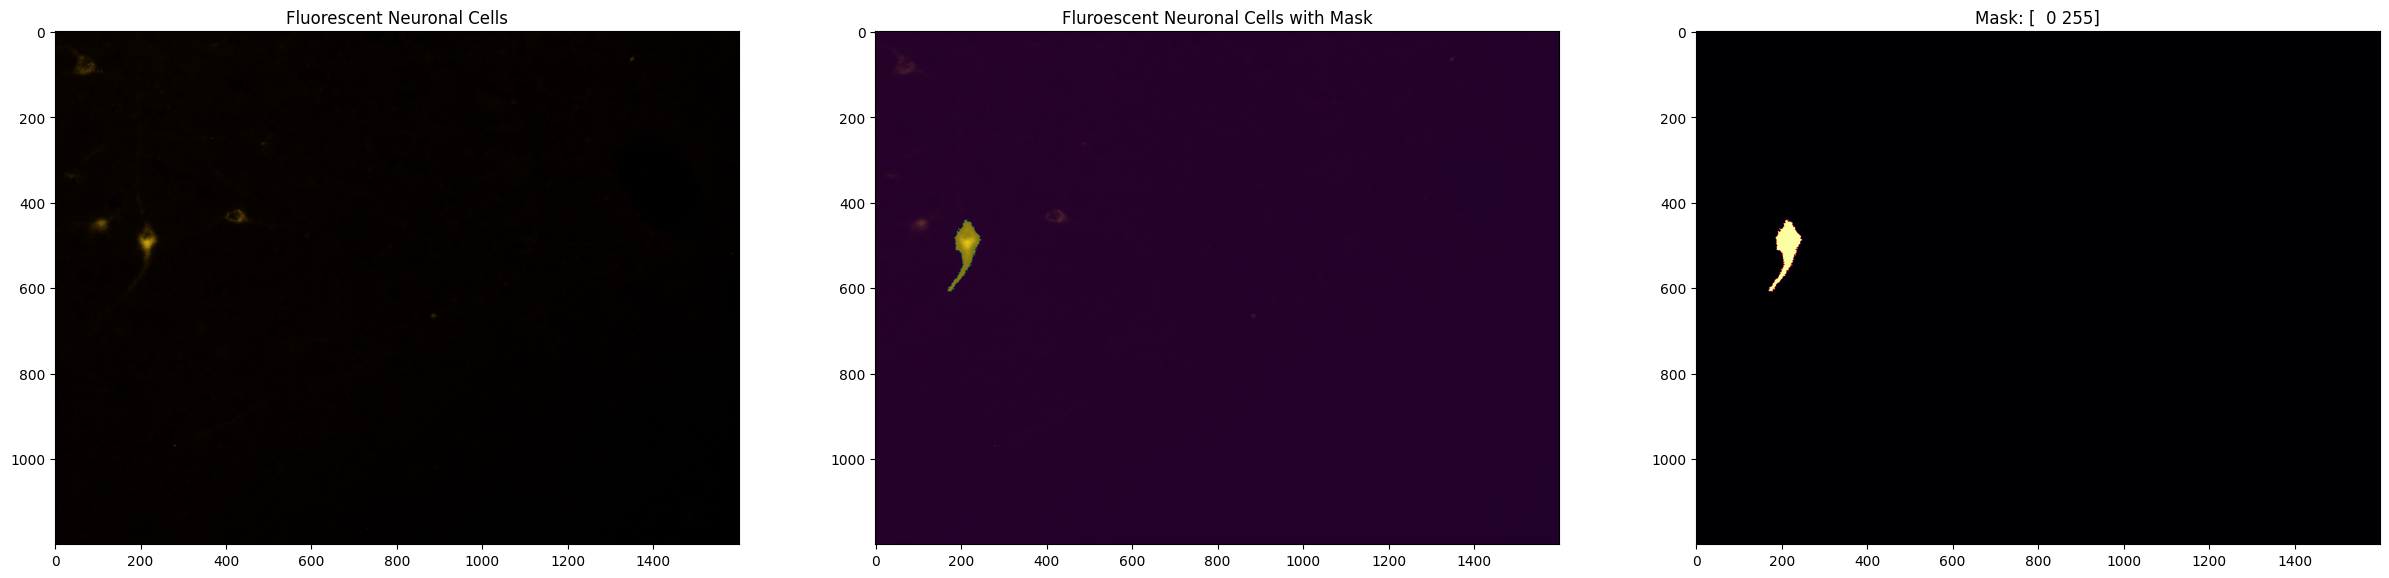

In [4]:
plt.figure(figsize=(30, 15))
plt.subplot(1, 3, 1)
plt.imshow(orig_image)
plt.title("Fluorescent Neuronal Cells")
plt.subplot(1, 3, 2)
plt.imshow(orig_image)
plt.imshow(orig_mask, cmap="viridis", alpha=0.5)
plt.title("Fluroescent Neuronal Cells with Mask")
plt.subplot(1, 3, 3)
plt.imshow(orig_mask, cmap="inferno")
plt.title(f"Mask: {np.unique(orig_mask)}")
plt.show()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


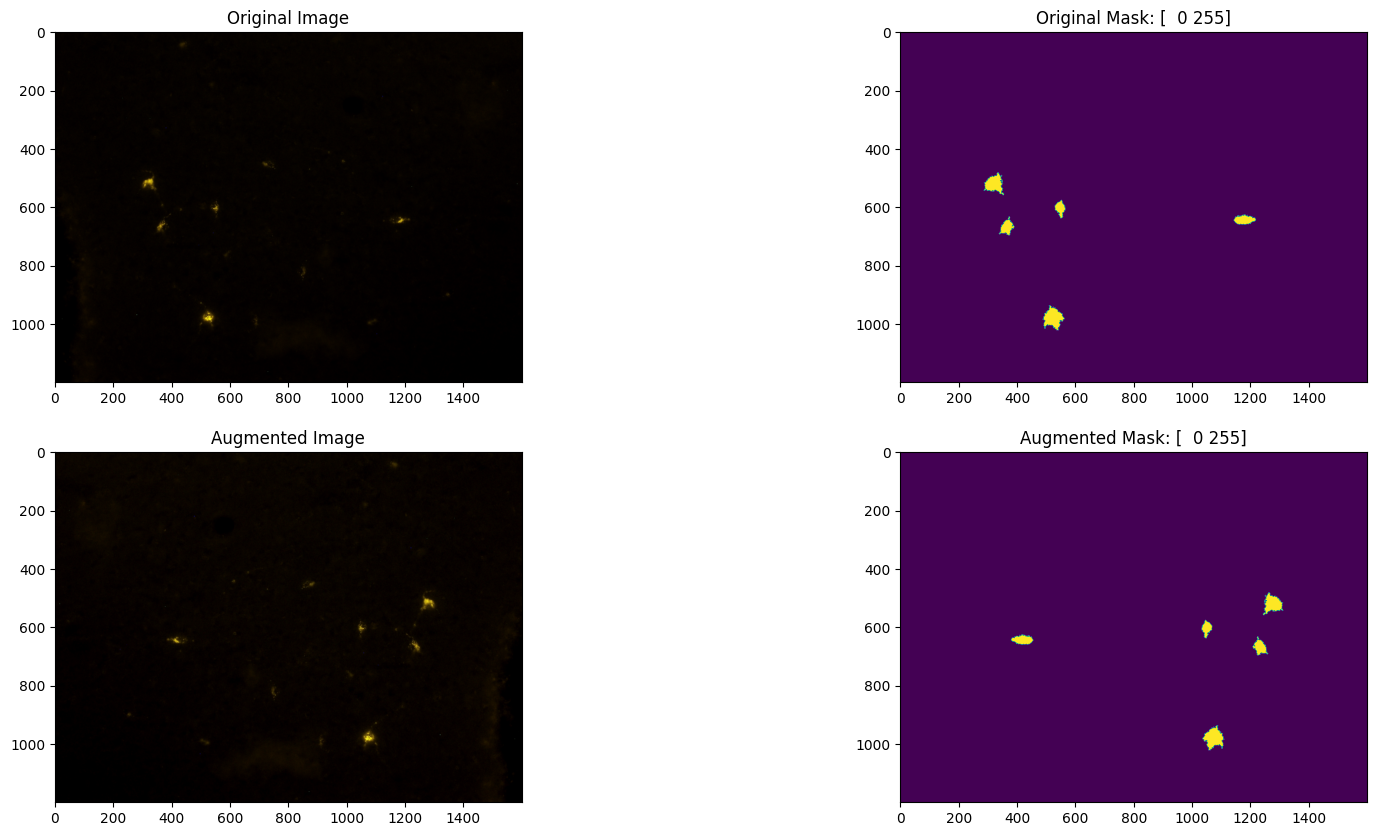

In [5]:
def test_augmentation():
    image_name = random.choice(os.listdir(os.path.join(RAW_DATA_PATH, "all_images", "images")))
    image_path = os.path.join(RAW_DATA_PATH, "all_images", "images", image_name)
    mask_path = os.path.join(RAW_DATA_PATH, "all_masks", "masks", image_name)

    orig_image = np.array(Image.open(image_path), dtype=np.uint8)
    orig_mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)

    image_augmentator = A.Compose(
        [
            A.HorizontalFlip(p=0.8),
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
            A.HueSaturationValue(p=0.8)
        ]
    )
    image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)

    augmented_images = image_augmentator(image=orig_image, mask=orig_mask)
    aug_image = augmented_images["image"]
    aug_mask = augmented_images["mask"]
    # inputs = image_processor.preprocess(augmented_images["image"], augmented_images["mask"])

    # ic(np.unique(inputs["labels"]))
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.subplot(2, 2, 2)
    plt.imshow(orig_mask)
    plt.title(f"Original Mask: {np.unique(orig_mask)}")
    plt.subplot(2, 2, 3)
    plt.imshow(aug_image)
    plt.title("Augmented Image")
    plt.subplot(2, 2, 4)
    plt.imshow(aug_mask)
    plt.title(f"Augmented Mask: {np.unique(aug_mask)}")
    plt.show()

test_augmentation()

In [6]:
class FluorescentNeuronalDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = RAW_DATA_PATH) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_processor = AutoImageProcessor.from_pretrained(
            MODEL_CHECKPOINT, do_reduce_labels=True
        )
        self.image_augmentator = A.Compose(
            [
                A.HorizontalFlip(p=0.8),
                A.RandomBrightnessContrast(p=0.8),
                A.RandomGamma(p=0.8),
                A.HueSaturationValue(p=0.8)
            ]
        )

    def _preprocess_masks(self, mask):
        mask_np = np.array(mask, dtype=np.float_)
        mask_np /= mask_np.max()
        mask_np = mask_np.astype(np.int16)
        return mask_np

    def _create_dataset(self):
        images_path = os.path.join(self.data_dir, "all_images", "images")
        masks_path = os.path.join(self.data_dir, "all_masks", "masks")
        list_images = os.listdir(images_path)

        images = []
        masks = []
        for image_filename in list_images:
            image_path = os.path.join(images_path, image_filename)
            mask_path = os.path.join(masks_path, image_filename)

            image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)

            images.append(image)
            masks.append(mask)

        dataset = Dataset.from_dict({"image": images, "mask": masks})

        # Split the dataset into train, val, and test sets
        dataset = dataset.train_test_split(test_size=0.1)
        train_val = dataset["train"]
        test_ds = dataset["test"]
        del dataset

        train_val = train_val.train_test_split(test_size=0.2)
        train_ds = train_val["train"]
        valid_ds = train_val["test"]
        del train_val

        dataset = DatasetDict({
            "train": train_ds,
            "validation": valid_ds,
            "test": test_ds
        })
        del train_ds, valid_ds, test_ds
        return dataset

    def _transform_train_data(self, batch):
        # Preprocess the images
        images = [img for img in batch["image"]]
        masks = [mask for mask in batch["mask"]]

        aug_inputs = self.image_augmentator(image=images, mask=masks)
        inputs = self.image_processor(aug_inputs["image"], aug_inputs["mask"])

        return inputs

    def _transform_valid_data(self, batch):
        # Preprocess the images
        images = [img for img in batch["image"]]
        images = self.image_processor(images)

        masks = [mask for mask in batch["mask"]]

        return inputs

    def setup(self, stage=None):
        dataset = self._create_dataset()
        train_ds = dataset["train"]
        valid_ds = dataset["validation"]
        test_ds = dataset["test"]

        if stage is None or stage == "fit":
            self.train_ds = train_ds.set_transform(self._transform_train_data)
            self.valid_ds = valid_ds.set_transform(self._transform_valid_data)
        if stage is None or stage == "test":
            self.test_ds = test_ds.set_transform(self._transform_valid_data)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def valid_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size)

In [7]:
image_augmentator = A.Compose(
    [
        A.HorizontalFlip(p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
        A.HueSaturationValue(p=0.8)
    ]
)
image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT, do_reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
def _create_dataset(data_dir: str = RAW_DATA_PATH):
    images_path = os.path.join(data_dir, "all_images", "images")
    masks_path = os.path.join(data_dir, "all_masks", "masks")
    list_images = os.listdir(images_path)

    images = []
    masks = []
    for image_filename in list_images:
        image_path = os.path.join(images_path, image_filename)
        mask_path = os.path.join(masks_path, image_filename)

        image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)

        images.append(image)
        masks.append(mask)

    dataset = Dataset.from_dict({"image": images, "mask": masks})

    # Split the dataset into train, val, and test sets
    dataset = dataset.train_test_split(test_size=0.1)
    train_val = dataset["train"]
    test_ds = dataset["test"]
    del dataset

    train_val = train_val.train_test_split(test_size=0.2)
    train_ds = train_val["train"]
    valid_ds = train_val["test"]
    del train_val

    dataset = DatasetDict({"train": train_ds, "validation": valid_ds, "test": test_ds})
    del train_ds, valid_ds, test_ds
    return dataset


def _transform_train_data(example):
    # Preprocess the images
    image = np.asarray(example["image"], dtype=np.uint8)
    mask = np.asarray(example["mask"], dtype=np.uint8)
    inputs = image_augmentator(image=image, mask=mask)

    # inputs = image_processor(
    #     images=inputs["image"],
    #     segmentation_maps=inputs["mask"],
    #     return_tensors="pt",
    # )

    return inputs


def setup(stage=None):
    dataset = _create_dataset()
    train_ds = dataset["train"]
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    if stage is None or stage == "fit":
        ic("This should work fine!")
        train_ds = train_ds.set_transform(_transform_train_data)

    return train_ds

In [9]:
dataset = _create_dataset()
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 203
    })
    validation: Dataset({
        features: ['image', 'mask'],
        num_rows: 51
    })
    test: Dataset({
        features: ['image', 'mask'],
        num_rows: 29
    })
})

In [12]:
train_ds = dataset["test"].map(_transform_train_data)

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

In [13]:
np.unique(train_ds[0]["mask"])

array([  0, 255])

In [ ]:
idx = np.random.randint(0, 282)

ds_image = complete_dataset[idx]["image"]
ds_mask = complete_dataset[idx]["mask"]

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(ds_image)
plt.title("Original Image")
plt.subplot(2, 1, 2)
plt.imshow(ds_mask)
plt.title(f"Original Mask: {np.unique(ds_mask)}")
plt.show()

## Create the Model

In [ ]:
class MobileVit(pl.LightningModule):
    def __init__(self, learning_rate, weight_decay) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.metric = evaluate.load("mean_iou")
        self.model = MobileViTForSemanticSegmentation.from_pretrained(MODEL_CHECKPOINT)